In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib


## Journal wants a sans serif font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
sns.axes_style({'font.family': ['sans-serif'],
                'font.sans-serif':['Arial']
               })

## Make exported plots' text seen as text in Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


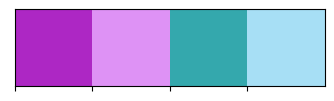

In [2]:
# Hex codes for ER and keratin in cell A, cell B
# as used in the paper

hex_ER_A  = "#AD27C4"
hex_ER_B  = "#DE92F5"
hex_KRT_A = "#34A8AD"
hex_KRT_B = "#A7DFF5"

#RGB_ER_A  = (173/255,  39/255, 196/255) #AD27C4
#RGB_ER_B  = (222/255, 146/255, 245/255) #DE92F5
#RGB_KRT_A = ( 52/255, 168/255, 173/255) #34A8AD
#RGB_KRT_B = (167/255, 223/255, 245/255) #A7DFF5

sns.set_palette(
    palette=[hex_ER_A, hex_ER_B, hex_KRT_A, hex_KRT_B],
    n_colors=4
)
sns.palplot(sns.color_palette())

The FIBSEM datasets that are being considered are:
- DSM-2 (8x8x8nm): horizontal ROI
- DSM-3 (4x4x4nm): tile 2-2

In [3]:
df = pd.read_csv("../csv/2023-01_merged_distances_DSM-3_and_DSM-2.csv",
                  usecols=["Name (NA)",
                           "Volume (nm³)", 
                           "Min Intensity (Distance_ER-A)",
                           "Min Intensity (Distance_ER-B)",
                           "Min Intensity (Distance_KRT-A)",
                           "Min Intensity (Distance_KRT-B)",
                          ])
df.head()

,Name (NA),Volume (nm³),Min Intensity (Distance_KRT-B),Min Intensity (Distance_KRT-A),Min Intensity (Distance_ER-A),Min Intensity (Distance_ER-B)
0,DSM2_tileWG_01,371200,1.210000e-07,4.380000e-07,2.430000e-07,3.390000e-08
1,DSM2_tileWG_02,299008,2.890000e-07,4.780000e-07,9.400000e-07,1.090000e-07
2,DSM2_tileWG_03,869376,2.990000e-08,3.580000e-08,1.050000e-06,2.880000e-08
3,DSM2_tileWG_04,363520,2.910000e-07,7.430000e-07,9.630000e-08,5.880000e-07
4,DSM2_tileWG_05,419840,1.130000e-08,3.750000e-08,2.320000e-07,1.060000e-07


## Convert the distance measurements from meters to nanometers and rename 


In [4]:
NANOMETERS_IN_METERS = 1e9
distance_columns = list(df.filter(regex = '^Min'))

for distance_col in distance_columns:
    df[distance_col] = df[distance_col] * NANOMETERS_IN_METERS
    
df.rename(columns = {
    "Name (NA)"                                : "Name",
    "Min Intensity (Distance_ER-A)"  : "ER - Cell A",
    "Min Intensity (Distance_ER-B)"  : "ER - Cell B",
    "Min Intensity (Distance_KRT-A)" : "Keratin - Cell A",
    "Min Intensity (Distance_KRT-B)" : "Keratin - Cell B"
},
          inplace=True
         )

### Create new column "Dataset" by parsing the "Name" column to determine whether the desmosome is from DSM-2 or DSM-3

In [5]:
df["Dataset"] = df["Name"].str.split('_').str[1]
df.head()

,Name,Volume (nm³),Keratin - Cell B,Keratin - Cell A,ER - Cell A,ER - Cell B,Dataset
0,DSM2_tileWG_01,371200,121.0,438.0,243.0,33.9,tileWG
1,DSM2_tileWG_02,299008,289.0,478.0,940.0,109.0,tileWG
2,DSM2_tileWG_03,869376,29.9,35.8,1050.0,28.8,tileWG
3,DSM2_tileWG_04,363520,291.0,743.0,96.3,588.0,tileWG
4,DSM2_tileWG_05,419840,11.3,37.5,232.0,106.0,tileWG


### Histogram the different distance measurements with a binwidth of 8nm
The number of desmosomes with touching ER/KRT will be given by the number of the first bin

In [6]:
dist_df = df.filter(like = "Cell")
distance_binwidth = 8 # nm
N = len(dist_df.index)
dist_df.head()

,Keratin - Cell B,Keratin - Cell A,ER - Cell A,ER - Cell B
0,121.0,438.0,243.0,33.9
1,289.0,478.0,940.0,109.0
2,29.9,35.8,1050.0,28.8
3,291.0,743.0,96.3,588.0
4,11.3,37.5,232.0,106.0


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


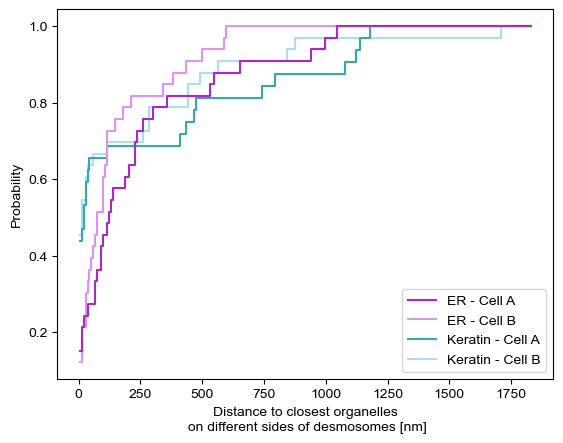

In [7]:
a_plot_stat = "probability"
a = sns.histplot(data=dist_df,
             bins=np.arange(dist_df.min().min(),
                            dist_df.max().max(),
                            distance_binwidth),
             hue_order=["ER - Cell A",
                        "ER - Cell B", 
                        "Keratin - Cell A", 
                        "Keratin - Cell B"],
             element="step", fill=False, stat=a_plot_stat, cumulative=True, common_norm=False,
            palette=sns.color_palette())
a.set_xlabel("Distance to closest organelles\n on different sides of desmosomes [nm]")
#a.set_xlim((0,1200))

plt.savefig(f"../plots/CDF_{a_plot_stat}.pdf", bbox_inches='tight')
plt.savefig(f"../plots/CDF_{a_plot_stat}_transparent.pdf", bbox_inches='tight', transparent = True)

## Look at number desmosomes with ER/KRT at various distances

In [8]:
def report_on_distance(df, distance):
    N = len(df.index)
    
    N_touching_ER_top = len(df.loc[df["ER - Cell A"] <= distance])
    N_touching_ER_bot = len(df.loc[df["ER - Cell B"] <= distance])
    N_touching_ER_both = len(df.loc[
        (df["ER - Cell A"] <= distance) & (df["ER - Cell B"] <= distance)])
    N_touching_ER_either = N_touching_ER_top + N_touching_ER_bot - N_touching_ER_both
    
    N_touching_KRT_top = len(df.loc[df["Keratin - Cell A"] <= distance])
    N_touching_KRT_bot = len(df.loc[df["Keratin - Cell B"] <= distance])
    N_touching_KRT_both = len(df.loc[
        (df["Keratin - Cell A"] <= distance) & (df["Keratin - Cell B"] <= distance)])
    N_touching_KRT_either = N_touching_KRT_top + N_touching_KRT_bot - N_touching_KRT_both
    
    print(f"Total number of desmosomes: {N}")
    print(f"Number of desmosomes with ER within {distance}nm on cell-A: {N_touching_ER_top}")
    print(f"Number of desmosomes with ER within {distance}nm on cell-B: {N_touching_ER_bot}")
    print(f"Number of desmosomes with ER within {distance}nm on both sides: {N_touching_ER_both}")
    print(f"Number of desmosomes with ER within {distance}nm on either side: {N_touching_ER_either}")
    print("\n")
    print(f"Number of desmosomes with KRT within {distance}nm on cell-A: {N_touching_KRT_top}")
    print(f"Number of desmosomes with KRT within {distance}nm on cell-B: {N_touching_KRT_bot}")
    print(f"Number of desmosomes with KRT within {distance}nm on both sides: {N_touching_KRT_both}")
    print(f"Number of desmosomes with KRT within {distance}nm on either side: {N_touching_KRT_either}")

#### First, how many desmosomes are actually touching ER or KRT?

In [9]:
touching_distance = 8 #nm

report_on_distance(df, touching_distance)

df.loc[(df["ER - Cell A"] <= touching_distance) | (df["ER - Cell B"] <= touching_distance) |
      (df["Keratin - Cell A"] <= touching_distance) | (df["Keratin - Cell B"] <= touching_distance)]

Total number of desmosomes: 33
Number of desmosomes with ER within 8nm on cell-A: 5
Number of desmosomes with ER within 8nm on cell-B: 4
Number of desmosomes with ER within 8nm on both sides: 1
Number of desmosomes with ER within 8nm on either side: 8


Number of desmosomes with KRT within 8nm on cell-A: 13
Number of desmosomes with KRT within 8nm on cell-B: 13
Number of desmosomes with KRT within 8nm on both sides: 10
Number of desmosomes with KRT within 8nm on either side: 16


,Name,Volume (nm³),Keratin - Cell B,Keratin - Cell A,ER - Cell A,ER - Cell B,Dataset
8,DSM2_tileWG_09,1693184,8.00,27.7,357.0,83.9,tileWG
12,DSM2_tileWG_13,5666304,8.00,8.0,229.0,107.0,tileWG
16,DSM2_tileWG_17,4145152,8.00,8.0,104.0,441.0,tileWG
17,DSM2_tileWG_18,4171776,8.00,8.0,204.0,19.6,tileWG
18,DSM2_tileWG_19,4371456,16.00,8.0,72.9,74.2,tileWG
19,DSM2_tileWG_20,4880384,8.00,8.0,8.0,148.0,tileWG
20,DSM2_tileWG_21,6946304,37.50,8.0,188.0,80.4,tileWG
21,DSM2_tileWG_22,6964224,8.00,8.0,125.0,102.0,tileWG
22,DSM2_tileWG_23,7132672,19.60,27.7,8.0,13.9,tileWG
23,DSM2_tileWG_24,10233856,11.30,8.0,146.0,8.0,tileWG


#### What about within a distance of 40nm?

In [10]:
contact_site_distance = 40 #nm
report_on_distance(df, contact_site_distance)

Total number of desmosomes: 33
Number of desmosomes with ER within 40nm on cell-A: 8
Number of desmosomes with ER within 40nm on cell-B: 10
Number of desmosomes with ER within 40nm on both sides: 3
Number of desmosomes with ER within 40nm on either side: 15


Number of desmosomes with KRT within 40nm on cell-A: 20
Number of desmosomes with KRT within 40nm on cell-B: 21
Number of desmosomes with KRT within 40nm on both sides: 19
Number of desmosomes with KRT within 40nm on either side: 22


#### What about a distance of 32nm?

In [11]:
alternative_contact_site_distance = 32 #nm
report_on_distance(df, alternative_contact_site_distance)

Total number of desmosomes: 33
Number of desmosomes with ER within 32nm on cell-A: 8
Number of desmosomes with ER within 32nm on cell-B: 9
Number of desmosomes with ER within 32nm on both sides: 3
Number of desmosomes with ER within 32nm on either side: 14


Number of desmosomes with KRT within 32nm on cell-A: 17
Number of desmosomes with KRT within 32nm on cell-B: 20
Number of desmosomes with KRT within 32nm on both sides: 16
Number of desmosomes with KRT within 32nm on either side: 21


#### Just for kicks, 30nm?

In [12]:
alternative_contact_site_distance2 = 30 #nm
report_on_distance(df, alternative_contact_site_distance2)
df.loc[(df["ER - Cell A"] <= alternative_contact_site_distance2) |
       (df["ER - Cell B"] <= alternative_contact_site_distance2)]

Total number of desmosomes: 33
Number of desmosomes with ER within 30nm on cell-A: 8
Number of desmosomes with ER within 30nm on cell-B: 9
Number of desmosomes with ER within 30nm on both sides: 3
Number of desmosomes with ER within 30nm on either side: 14


Number of desmosomes with KRT within 30nm on cell-A: 17
Number of desmosomes with KRT within 30nm on cell-B: 20
Number of desmosomes with KRT within 30nm on both sides: 16
Number of desmosomes with KRT within 30nm on either side: 21


,Name,Volume (nm³),Keratin - Cell B,Keratin - Cell A,ER - Cell A,ER - Cell B,Dataset
2,DSM2_tileWG_03,869376,29.90,35.80,1050.0,28.8,tileWG
6,DSM2_tileWG_07,610304,445.00,1130.00,17.9,341.0,tileWG
17,DSM2_tileWG_18,4171776,8.00,8.00,204.0,19.6,tileWG
19,DSM2_tileWG_20,4880384,8.00,8.00,8.0,148.0,tileWG
22,DSM2_tileWG_23,7132672,19.60,27.70,8.0,13.9,tileWG
23,DSM2_tileWG_24,10233856,11.30,8.00,146.0,8.0,tileWG
24,DSM2_tileWG_25,12183040,8.00,8.00,25.3,40.8,tileWG
25,DSM2_tileWG_26,16123904,8.00,8.00,41.6,8.0,tileWG
26,DSM2_tileWG_27,37683712,8.00,8.00,69.7,8.0,tileWG
27,DSM3_tile2-2_01,1014144,497.00,122.00,4.0,120.0,tile2-2


### What if we only look at the desmosomes that have nearby keratin?

In [13]:
keratin_distance = 50 #nm
df_near_keratin = df.loc[
    (df["Keratin - Cell A"] <= keratin_distance) | (df["Keratin - Cell B"] <= keratin_distance)]
df_near_keratin

,Name,Volume (nm³),Keratin - Cell B,Keratin - Cell A,ER - Cell A,ER - Cell B,Dataset
2,DSM2_tileWG_03,869376,29.90,35.80,1050.0,28.8,tileWG
4,DSM2_tileWG_05,419840,11.30,37.50,232.0,106.0,tileWG
7,DSM2_tileWG_08,1520128,28.80,17.90,302.0,119.0,tileWG
8,DSM2_tileWG_09,1693184,8.00,27.70,357.0,83.9,tileWG
12,DSM2_tileWG_13,5666304,8.00,8.00,229.0,107.0,tileWG
14,DSM2_tileWG_15,2191360,61.40,33.00,82.4,219.0,tileWG
16,DSM2_tileWG_17,4145152,8.00,8.00,104.0,441.0,tileWG
17,DSM2_tileWG_18,4171776,8.00,8.00,204.0,19.6,tileWG
18,DSM2_tileWG_19,4371456,16.00,8.00,72.9,74.2,tileWG
19,DSM2_tileWG_20,4880384,8.00,8.00,8.0,148.0,tileWG


In [14]:
report_on_distance(df_near_keratin, 32)

Total number of desmosomes: 22
Number of desmosomes with ER within 32nm on cell-A: 6
Number of desmosomes with ER within 32nm on cell-B: 9
Number of desmosomes with ER within 32nm on both sides: 3
Number of desmosomes with ER within 32nm on either side: 12


Number of desmosomes with KRT within 32nm on cell-A: 17
Number of desmosomes with KRT within 32nm on cell-B: 20
Number of desmosomes with KRT within 32nm on both sides: 16
Number of desmosomes with KRT within 32nm on either side: 21


### What if we look at the desmosome volume?

In [15]:
min_dsm_volume = 4e6 #nm^3
df_larger_desmosomes = df.loc[df["Volume (nm³)"] >= min_dsm_volume]
df_larger_desmosomes

,Name,Volume (nm³),Keratin - Cell B,Keratin - Cell A,ER - Cell A,ER - Cell B,Dataset
12,DSM2_tileWG_13,5666304,8.0,8.0,229.0,107.0,tileWG
16,DSM2_tileWG_17,4145152,8.0,8.0,104.0,441.0,tileWG
17,DSM2_tileWG_18,4171776,8.0,8.0,204.0,19.6,tileWG
18,DSM2_tileWG_19,4371456,16.0,8.0,72.9,74.2,tileWG
19,DSM2_tileWG_20,4880384,8.0,8.0,8.0,148.0,tileWG
20,DSM2_tileWG_21,6946304,37.5,8.0,188.0,80.4,tileWG
21,DSM2_tileWG_22,6964224,8.0,8.0,125.0,102.0,tileWG
22,DSM2_tileWG_23,7132672,19.6,27.7,8.0,13.9,tileWG
23,DSM2_tileWG_24,10233856,11.3,8.0,146.0,8.0,tileWG
24,DSM2_tileWG_25,12183040,8.0,8.0,25.3,40.8,tileWG


In [16]:
report_on_distance(df_larger_desmosomes, 50)

Total number of desmosomes: 14
Number of desmosomes with ER within 50nm on cell-A: 6
Number of desmosomes with ER within 50nm on cell-B: 7
Number of desmosomes with ER within 50nm on both sides: 4
Number of desmosomes with ER within 50nm on either side: 9


Number of desmosomes with KRT within 50nm on cell-A: 14
Number of desmosomes with KRT within 50nm on cell-B: 14
Number of desmosomes with KRT within 50nm on both sides: 14
Number of desmosomes with KRT within 50nm on either side: 14


### We can compare the shortest distances that we measure with FIBSEM and ask if instead the closest ER/KRT was in a different idealized position, could we resolve it?

#### If the ER/KRT were instead positioned laterally from the outer dense plaque, how many desmosomes would appear colocalized with our spinning disk confocal?

In [17]:
lat_optical_limit_distance = 250 #nm
report_on_distance(df, lat_optical_limit_distance)

Total number of desmosomes: 33
Number of desmosomes with ER within 250nm on cell-A: 24
Number of desmosomes with ER within 250nm on cell-B: 27
Number of desmosomes with ER within 250nm on both sides: 20
Number of desmosomes with ER within 250nm on either side: 31


Number of desmosomes with KRT within 250nm on cell-A: 22
Number of desmosomes with KRT within 250nm on cell-B: 23
Number of desmosomes with KRT within 250nm on both sides: 21
Number of desmosomes with KRT within 250nm on either side: 24


#### If the ER/KRT were positioned axially from the outer dense plaque, how many desmosomes would appear colocalized with our spinning disk confocal

In [18]:
axial_optical_limit_distance = 600 #nm
report_on_distance(df, axial_optical_limit_distance)

Total number of desmosomes: 33
Number of desmosomes with ER within 600nm on cell-A: 29
Number of desmosomes with ER within 600nm on cell-B: 33
Number of desmosomes with ER within 600nm on both sides: 29
Number of desmosomes with ER within 600nm on either side: 33


Number of desmosomes with KRT within 600nm on cell-A: 26
Number of desmosomes with KRT within 600nm on cell-B: 30
Number of desmosomes with KRT within 600nm on both sides: 26
Number of desmosomes with KRT within 600nm on either side: 30


### What correlations exist for ER and KRT?

### Volume and keratin
- Small desmosomes are less likely to have nearby keratin.
- However, desmosomes of any volume can have nearby keratin

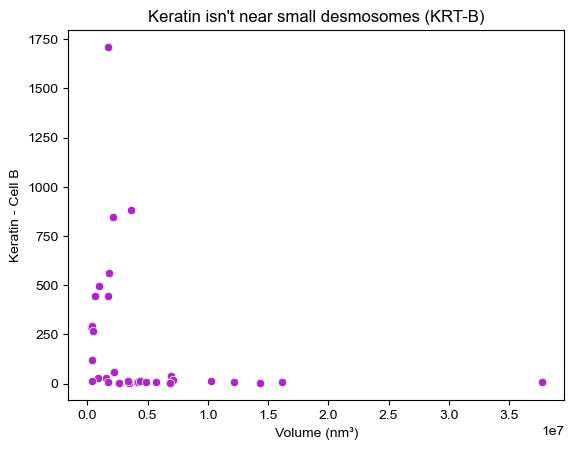

In [19]:
scatter = sns.scatterplot(x = df["Volume (nm³)"], 
                          y = df["Keratin - Cell B"],
                          #size=df["Volume (nm³)"],
               ).set(title = "Keratin isn't near small desmosomes (KRT-B)")

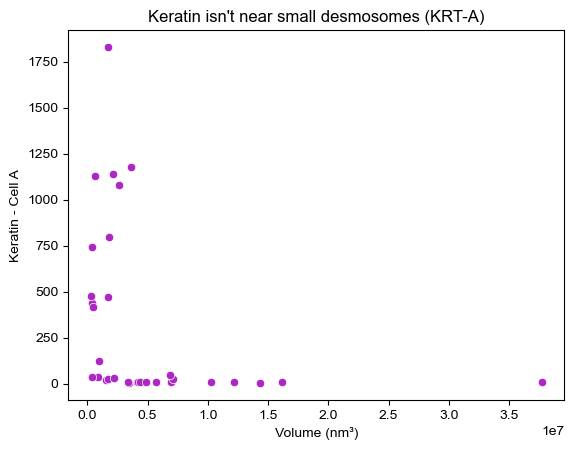

In [20]:
scatter = sns.scatterplot(x = df["Volume (nm³)"], 
                          y = df["Keratin - Cell A"],
                          #size=df["Volume (nm³)"],
               ).set(title = "Keratin isn't near small desmosomes (KRT-A)")

#### Keratin comparisons
- Larger desmosomes have keratin from both cells as shown by the cluster.
- Unsurprisingly, if keratin is present at a desmosome on one cell, then it's present at the other cell. There is one small caveat: some small desmosomes are close to bigger desmosomes, so they may not actually have keratin of their own.

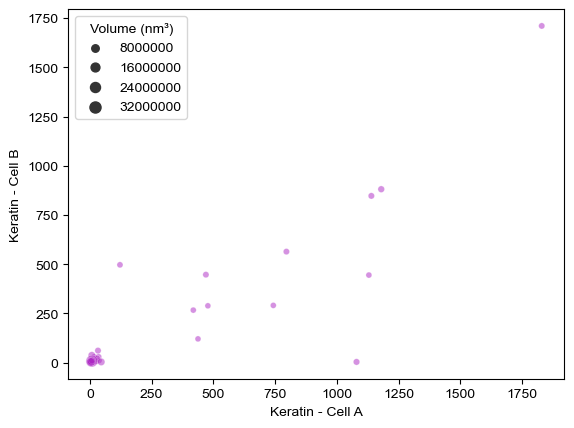

In [21]:
scatter = sns.scatterplot(x = df["Keratin - Cell A"], 
                          y = df["Keratin - Cell B"],
                          size=df["Volume (nm³)"],
                          alpha = 0.5
               )

### A closer look at the desmosomes with keratin at both sides

(0.0, 80.0)

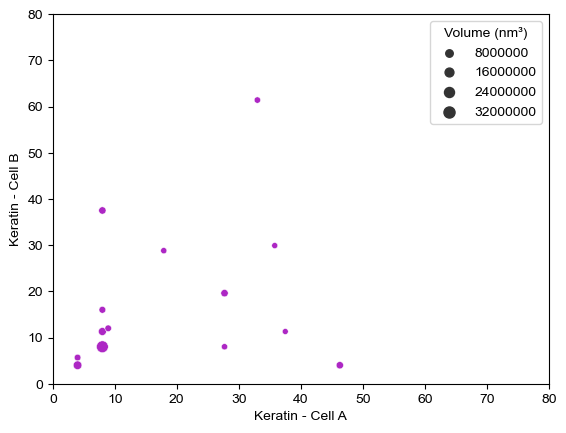

In [22]:
#sns.set(rc={"figure.figsize":(10, 10)})

limited_scatter = sns.scatterplot(x = df["Keratin - Cell A"], 
                                  y = df["Keratin - Cell B"],
                                  size=df["Volume (nm³)"],
                                 )
max_ax_limit = 80
limited_scatter.set_xlim(0, max_ax_limit)
limited_scatter.set_ylim(0, max_ax_limit)

## ER and volume

Here's every datapoint for whether having KRT on one side is correlated with having ER on the same side.

Text(0.5, 1.0, 'KRT and ER on the same side (B) \n(all datapoints)')

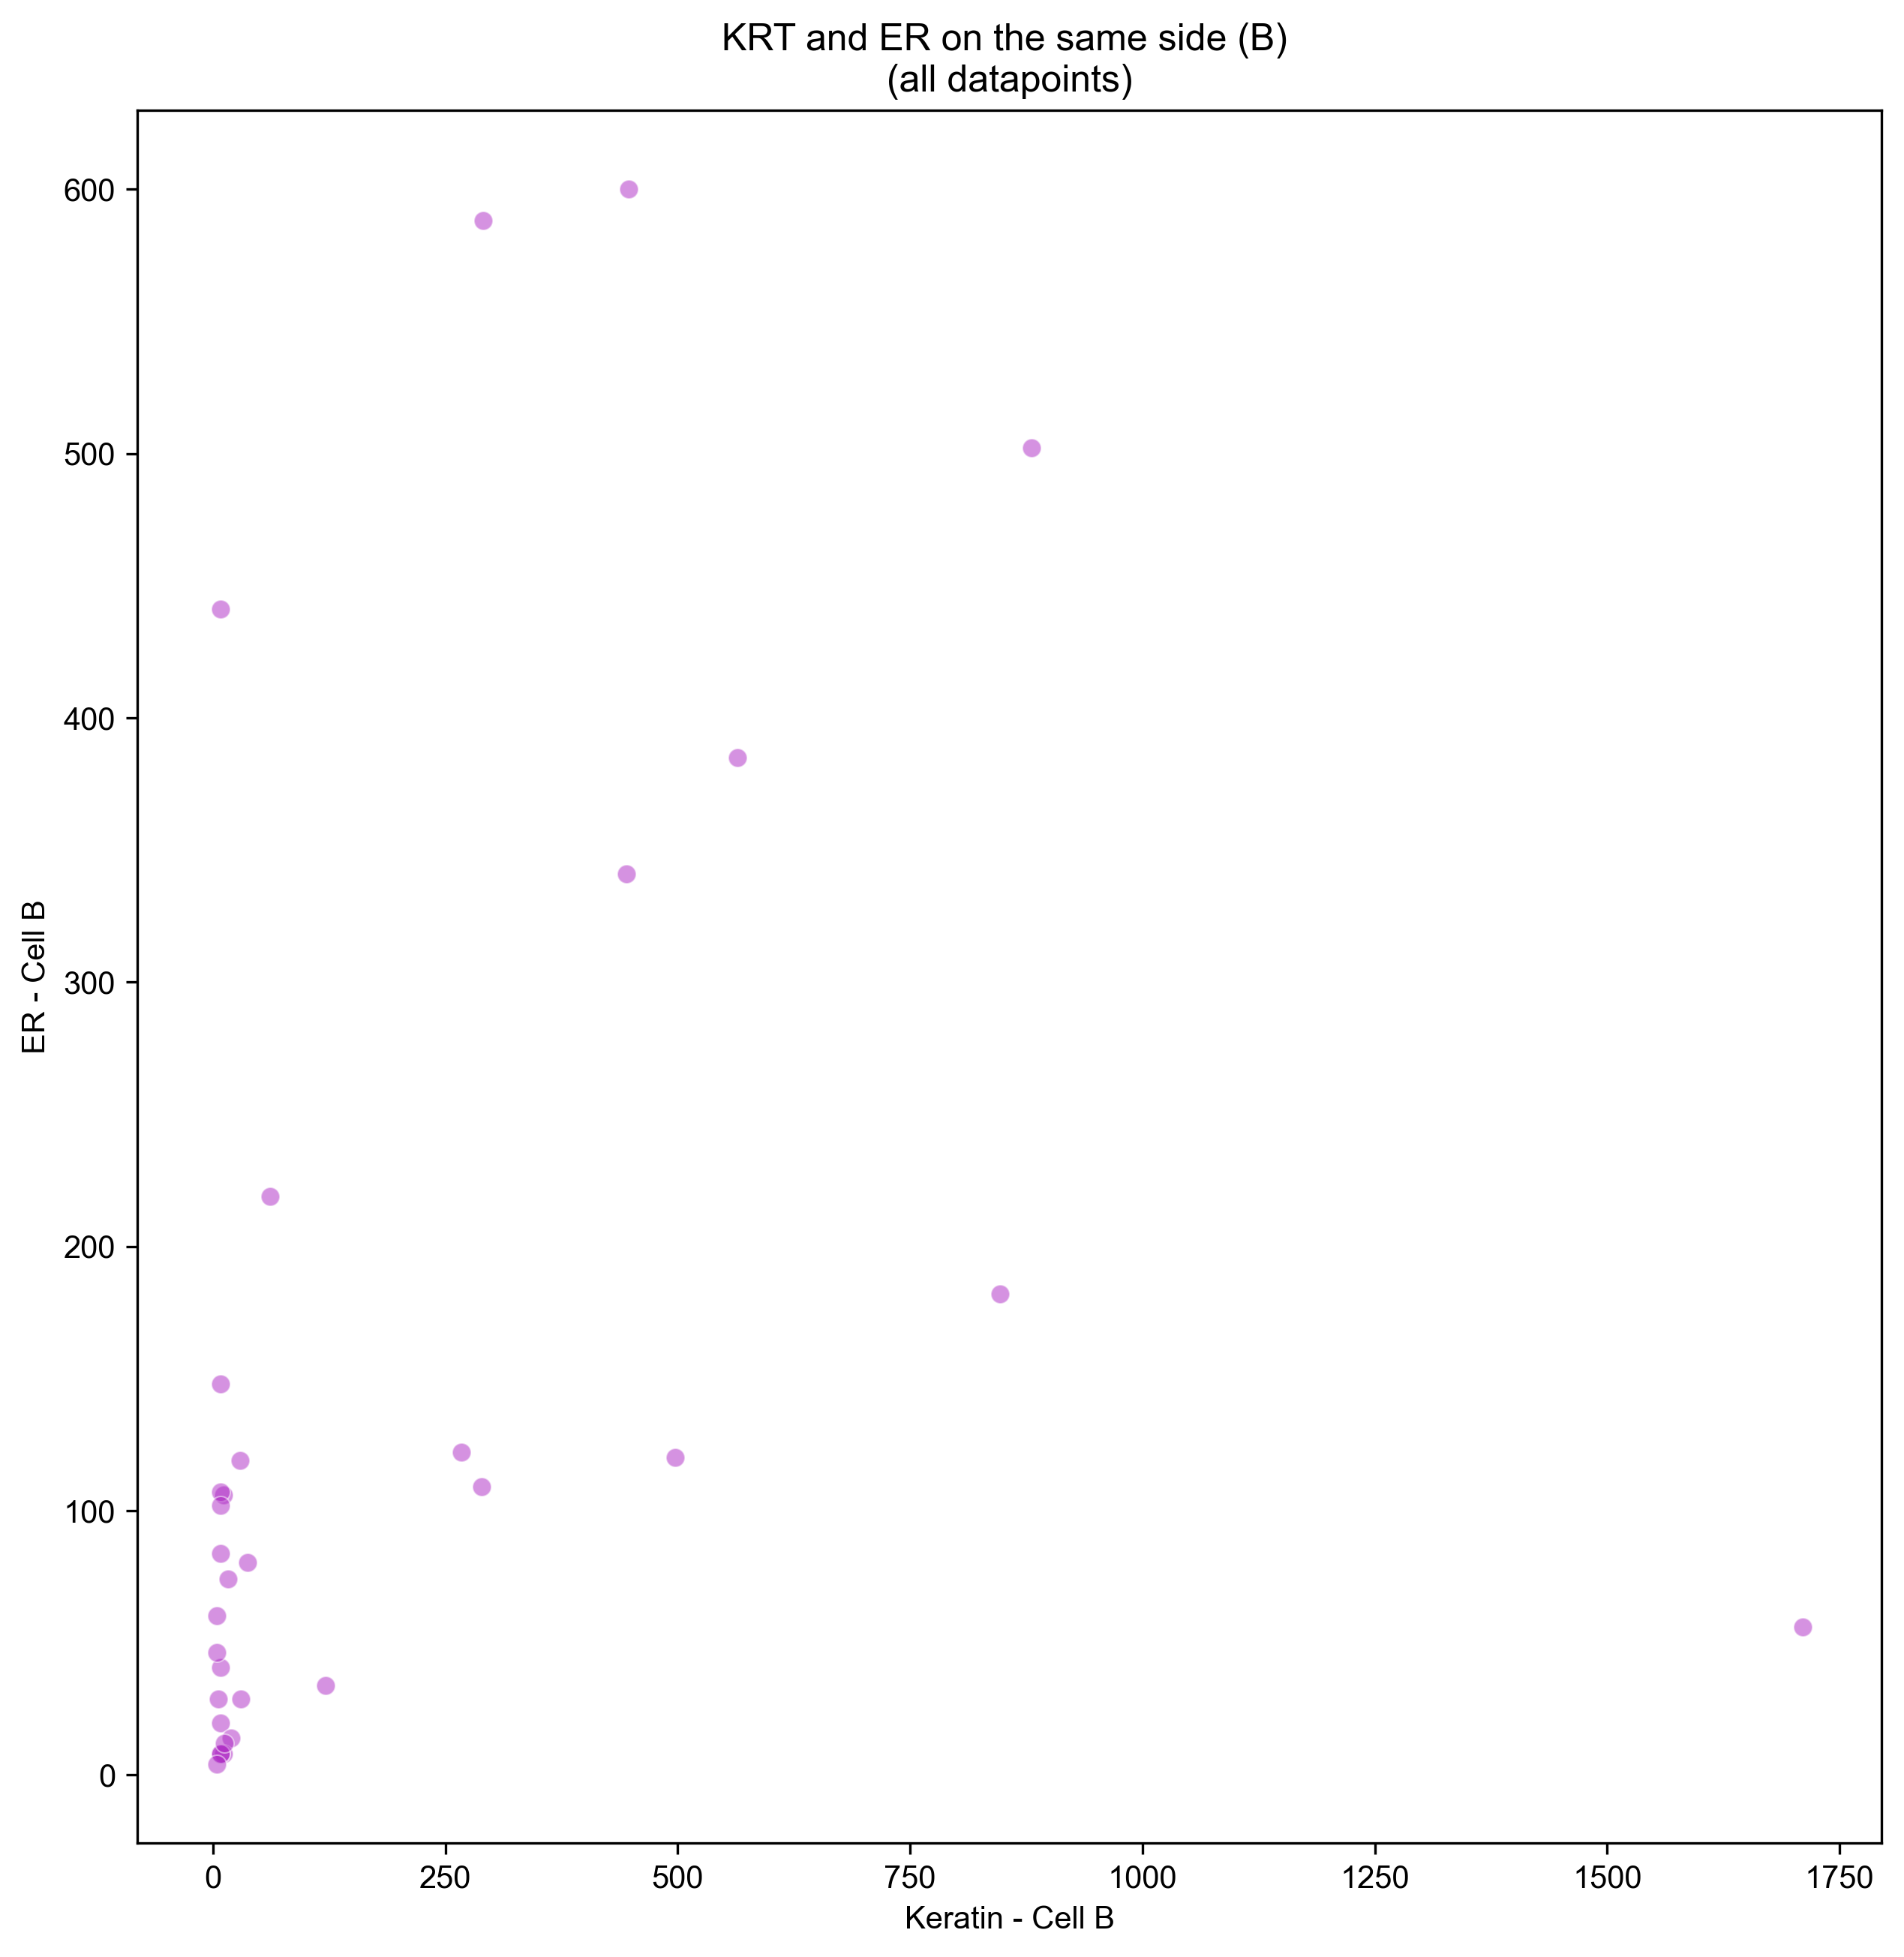

In [23]:
#sns.set(rc={"figure.figsize":(10, 10)})
#sns.set(font_scale = 2)
fig, ER_KRT_scatter = plt.subplots(figsize=(10,10), dpi=300)

ER_KRT_scatter = sns.scatterplot(x = df["Keratin - Cell B"], 
                                 y = df["ER - Cell B"],
                                 data=df,
                                alpha = 0.5)
                          #size=df["Volume (nm³)"],
               #)#.set(
    #title = "Does KRT on one side correlate with ER on the same side? \n(all)")
    
#max_ax_limit = max(df["Distance_to_KRT-bot [nm]"].max(), df["Distance_to_ER-bot [nm]"].max())
#ER_KRT_scatter.set_xlim(0, max_ax_limit)
#ER_KRT_scatter.set_ylim(0, max_ax_limit)
#ER_KRT_scatter.set_xlim(left=0, right=1750)
#ER_KRT_scatter.set_ylim(bottom=0, top=1750)
plt.title("KRT and ER on the same side (B) \n(all datapoints)")

It is tough to see the correlation where KRT is close to desmosomees, so let's zoom in

Text(0.5, 1.0, 'ER and KRT on the same side (B) \n(Limited to within 300nm)')

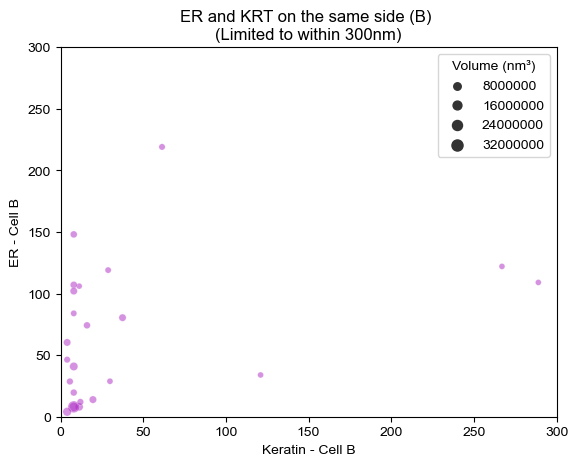

In [24]:
#sns.set(rc={"figure.figsize":(10, 10)})
#sns.set(font_scale = 2)

limited_ER_KRT_scatter = sns.scatterplot(x = df["Keratin - Cell B"], 
                                         y = df["ER - Cell B"],
                                         size = df["Volume (nm³)"],
                                         alpha = 0.5
                                        )
max_ax_limit = 300
limited_ER_KRT_scatter.set_xlim(0, max_ax_limit)
limited_ER_KRT_scatter.set_ylim(0, max_ax_limit)
plt.title(f"ER and KRT on the same side (B) \n(Limited to within {max_ax_limit}nm)")

Text(0.5, 1.0, 'ER and KRT on the same side (B) \n(Limited to within 300nm)')

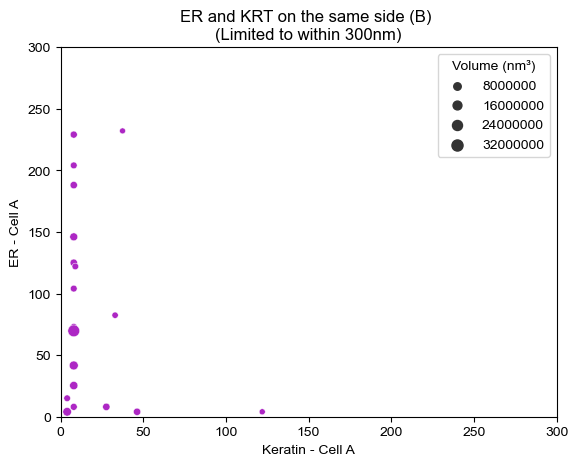

In [25]:
#sns.set(rc={"figure.figsize":(10, 10)})

limited_ER_KRT_scatter = sns.scatterplot(x = df["Keratin - Cell A"], 
                                         y = df["ER - Cell A"],
                                         size = df["Volume (nm³)"],
                                        )

max_ax_limit = 300
limited_ER_KRT_scatter.set_xlim(0, max_ax_limit)
limited_ER_KRT_scatter.set_ylim(0, max_ax_limit)
plt.title(f"ER and KRT on the same side (B) \n(Limited to within {max_ax_limit}nm)")

Text(0.5, 1.0, 'ER on both sides \n(Limited to within 600nm)')

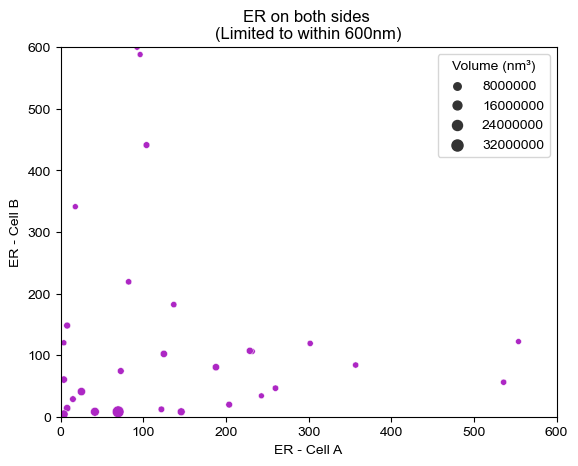

In [26]:
#sns.set(rc={"figure.figsize":(10, 10)})

limited_ER_KRT_scatter = sns.scatterplot(x = df["ER - Cell A"], 
                                         y = df["ER - Cell B"],
                                         size = df["Volume (nm³)"],
                                        )

max_ax_limit = 600
limited_ER_KRT_scatter.set_xlim(0, max_ax_limit)
limited_ER_KRT_scatter.set_ylim(0, max_ax_limit)
plt.title(f"ER on both sides \n(Limited to within {max_ax_limit}nm)")

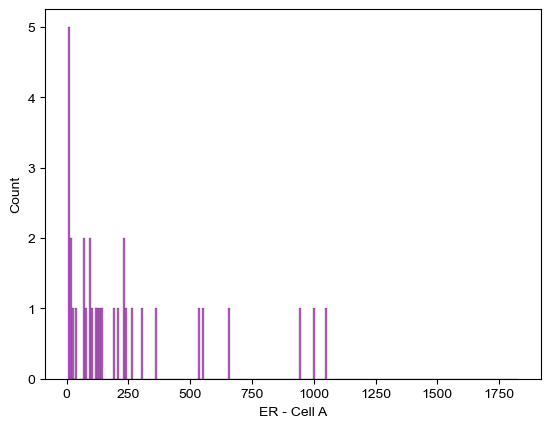

In [27]:
#dist_ER = df.filter(regex = "^Distance_to_ER")
distance_binwidth = 8 # nm

ax = sns.histplot(df["ER - Cell A"],
            bins=np.arange(dist_df.min().min(),
                                 dist_df.max().max(),
                                 distance_binwidth
                                ),
            #multiple="stack",
            stat="count")
#ax.set_ylim(0, 100)
#ax.set_xlim(0, 1100)

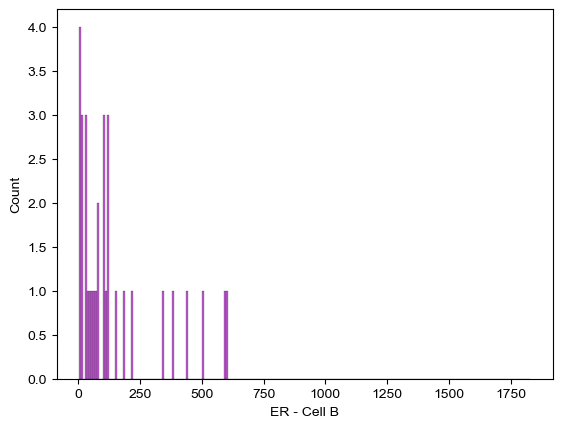

In [28]:
distance_binwidth = 8 # nm
ax = sns.histplot(df["ER - Cell B"],
            bins=np.arange(dist_df.min().min(),
                                 dist_df.max().max(),
                                 distance_binwidth
                                ),
            #multiple="stack",
            stat="count")

#ax.set_ylim(0, 100)
#ax.set_xlim(0, 1100)

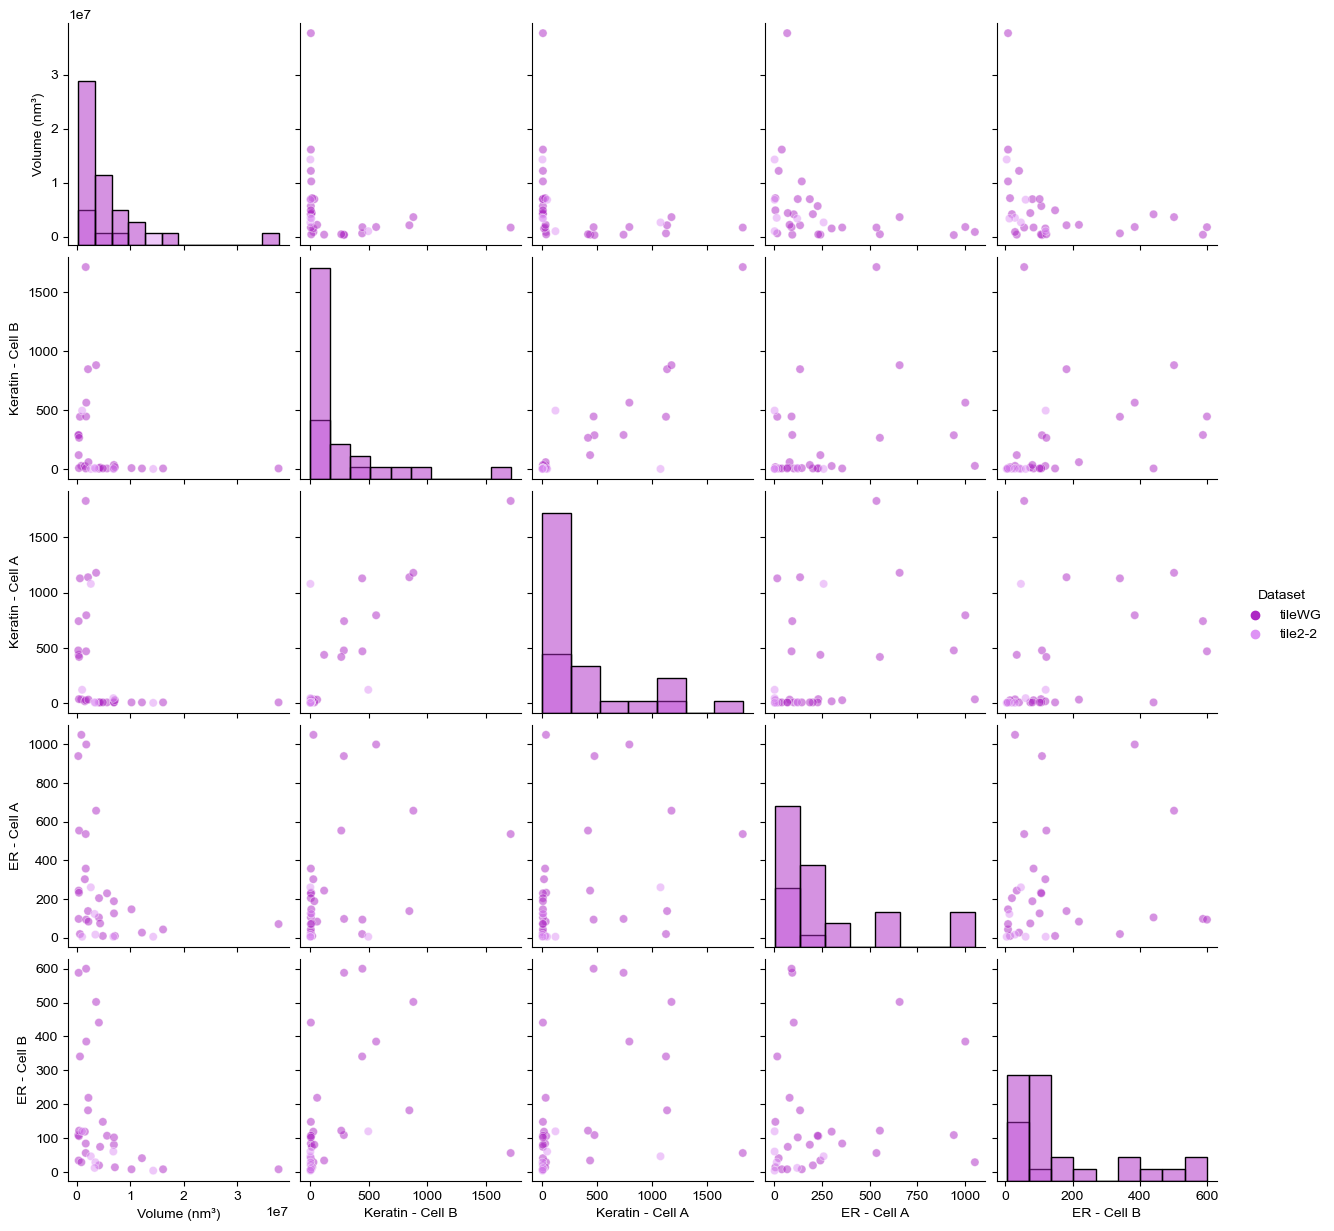

In [29]:
g = sns.pairplot(df, hue="Dataset", diag_kind='hist', 
                 plot_kws=dict(alpha = 0.5), 
                 diag_kws=dict(alpha = 0.5),
                )
#g.map_lower(sns.kdeplot, levels = 2, color=".2")